In [25]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
import gensim
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import to_categorical
import pickle

nltk.download('punkt')

SEQUENCE_LENGTH = 100
EMBEDDING_SIZE = 100
BATCH_SIZE = 64
PAD_WORD = "__PAD__"
WORD_EMBEDDING_FILE = 'word_embedding.csv'
TOKENIZER_FILE = 'tokenizer.pickle'


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\isjha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<h1>Preprocess Raw Data</h1>

In [9]:
data = pd.read_csv("dota2_chat_messages.csv", encoding="utf_8", usecols=["match", "slot", "text"])
data = data.astype({"match": int, "slot": int, "text": str})
data.head(10)

,match,slot,text
0,0,9,ладно гг
1,0,9,изи
2,0,9,од
3,0,9,ебаный
4,0,9,мусор на войде
5,0,9,мусор
6,0,9,на войде
7,0,9,репорт
8,0,9,100%
9,1,0,twitch.tv/rage_channel


In [14]:
data = data.groupby(['match', 'slot'])['text'].apply('. '.join)
data.reset_index()
data.head(10)

match  slot
0      9       ладно гг . изи. од. ебаный. мусор на войде. му...
1      0       twitch.tv/rage_channel. https://www.twitch.tv/...
       4       где даша?. даша домой. долбоеб сука на дизрапторе
       6       даун с 1 тычки забашил . шок . стример харду с...
       7                                   2 даша подряд . баша 
       8                                                     )))
2      0       yes dog. yeah . fast and furious. too fas. hah...
       2                               no idiot. we too pro. lol
       4                                HAHAH. COMMEND ME TY. EZ
       6                                              carry. lul
Name: text, dtype: object

In [15]:
data = data.reset_index()
data.head(10)

,match,slot,text
0,0,9,ладно гг . изи. од. ебаный. мусор на войде. му...
1,1,0,twitch.tv/rage_channel. https://www.twitch.tv/...
2,1,4,где даша?. даша домой. долбоеб сука на дизрапторе
3,1,6,даун с 1 тычки забашил . шок . стример харду с...
4,1,7,2 даша подряд . баша
5,1,8,)))
6,2,0,yes dog. yeah . fast and furious. too fas. hah...
7,2,2,no idiot. we too pro. lol
8,2,4,HAHAH. COMMEND ME TY. EZ
9,2,6,carry. lul


In [17]:
data.to_csv("dota2_chat_joined.csv")

In [18]:
data.describe()

,match,slot
count,4.747547e+06,4.747547e+06
mean,4.999057e+05,4.493503e+00
std,2.887862e+05,2.873926e+00
min,0.000000e+00,0.000000e+00
25%,2.497860e+05,2.000000e+00
50%,4.999710e+05,5.000000e+00
75%,7.500870e+05,7.000000e+00
max,9.999990e+05,9.000000e+00


<h1>Word Embedding<h1>

In [32]:
data_word_embedding = pd.read_csv("dota2_chat_final.csv", encoding="latin_1", usecols=["match", "slot", "text"])
data_word_embedding.head(10)

,match,slot,text
0,2,0,yes dog. yeah . fast and furious. too fas. hah...
1,2,2,no idiot. we too pro. lol
2,2,4,HAHAH. COMMEND ME TY. EZ
3,6,0,so ya mama likes dick ehh?. figures. ur not ev...
4,6,1,reprot. SAD. fucking reported axe. WORST HOOK ...
5,6,3,gg
6,6,4,axe is axe
7,6,8,sorry nex. i killed u . almost . gg
8,8,6,PUSH. not defending. dodger lc. swap commend t...
9,9,3,what. jeje fAM. free farming ls. not coming in...


In [34]:
data_word_embedding_numpy = data_word_embedding.drop(columns=['match', 'slot']).to_numpy().flatten()

In [52]:
# document to sentences
word_embedding_sentences = []
for index, document in enumerate(data_word_embedding_numpy):
    sentences = sent_tokenize(document);
    for index, sentence in enumerate(sentences):
        word_embedding_sentences.append(sentence)    
word_embedding_sentences

['yes dog.',
 'yeah .',
 'fast and furious.',
 'too fas.',
 'haha.',
 'sad',
 'no idiot.',
 'we too pro.',
 'lol',
 'HAHAH.',
 'COMMEND ME TY.',
 'EZ',
 'so ya mama likes dick ehh?.',
 'figures.',
 'ur not even a good hooker kid.',
 'passive shadow blade?.',
 'gg',
 'reprot.',
 'SAD.',
 'fucking reported axe.',
 'WORST HOOK IN HISTORY.',
 'YOU THOUGHT.',
 'IM THE #1 ROAMER NA.',
 'STUPIDD PIUDGE.',
 'STUPID!.',
 'nice ult medusa.',
 'commended.',
 'DOWNYS  GET DUMKED.',
 'ez game.',
 'Ty ty .',
 'SOOO EZQ!!.',
 'COMMEND ME!.',
 'COMMAND ME!',
 '!',
 'gg',
 'axe is axe',
 'sorry nex.',
 'i killed u .',
 'almost .',
 'gg',
 'PUSH.',
 'not defending.',
 'dodger lc.',
 'swap commend ty.',
 'swap commend ty',
 'what.',
 'jeje fAM.',
 'free farming ls.',
 'not coming into play.',
 'let end.',
 'storm fat yet.',
 'zZZ.',
 'ok. U useless anyways.',
 'does it matter.',
 '30mins in.',
 'cant seem to hit a singel call.',
 'ROFL.',
 'still didnt hirt.',
 'Aha.',
 'better share hero contorl.',
 'to

In [49]:
# melakukan tokenisasi (menghilangkan tanda baca, dll)
# membuat dictionary setiap token
word_embedding_tokenizer = Tokenizer(oov_token='OOV')
word_embedding_tokenizer.fit_on_texts(word_embedding_sentences)
word_embedding_tokenizer.word_index

{'OOV': 1,
 'i': 2,
 'gg': 3,
 'u': 4,
 'you': 5,
 'me': 6,
 'lol': 7,
 'to': 8,
 'ez': 9,
 'game': 10,
 'a': 11,
 'report': 12,
 'and': 13,
 'this': 14,
 'is': 15,
 'mid': 16,
 'end': 17,
 'my': 18,
 'haha': 19,
 'so': 20,
 'no': 21,
 'the': 22,
 'team': 23,
 'just': 24,
 'for': 25,
 'not': 26,
 'fucking': 27,
 'we': 28,
 'nice': 29,
 'ur': 30,
 'wp': 31,
 'can': 32,
 'ty': 33,
 'dont': 34,
 'xd': 35,
 'fuck': 36,
 'he': 37,
 'that': 38,
 'im': 39,
 'lc': 40,
 'what': 41,
 'go': 42,
 'noob': 43,
 'how': 44,
 'in': 45,
 'have': 46,
 'ggwp': 47,
 'pls': 48,
 'win': 49,
 'd': 50,
 'are': 51,
 'commend': 52,
 'all': 53,
 'why': 54,
 'of': 55,
 'shit': 56,
 'am': 57,
 'guys': 58,
 'do': 59,
 'your': 60,
 'it': 61,
 'cant': 62,
 'man': 63,
 'now': 64,
 'pa': 65,
 'dog': 66,
 'good': 67,
 'at': 68,
 'know': 69,
 'see': 70,
 'wait': 71,
 'like': 72,
 'ursa': 73,
 'on': 74,
 'get': 75,
 'ok': 76,
 '2': 77,
 'pro': 78,
 'got': 79,
 'was': 80,
 'will': 81,
 'with': 82,
 'if': 83,
 'wtf': 84,
 'b

In [50]:
# encoding setiap token sesuai dengan nomor indexnya
word_embedding_sequences = word_embedding_tokenizer.texts_to_sequences(word_embedding_sentences)
word_embedding_sequences

[[231, 66],
 [174],
 [114, 13, 771],
 [175, 772],
 [19],
 [92],
 [21, 156],
 [28, 175, 78],
 [7],
 [286],
 [52, 6, 33],
 [9],
 [20, 287, 365, 773, 232, 774],
 [775],
 [30, 26, 115, 11, 67, 776, 233],
 [288, 366, 487],
 [3],
 [777],
 [92],
 [27, 194, 107],
 [234, 289, 45, 778],
 [5, 367],
 [39, 22, 116, 779, 780],
 [781, 782],
 [131],
 [29, 783, 176],
 [784],
 [785, 75, 786],
 [9, 10],
 [33, 33],
 [787, 788],
 [52, 6],
 [789, 6],
 [],
 [3],
 [107, 15, 107],
 [126, 790],
 [2, 235, 4],
 [290],
 [3],
 [236],
 [26, 791],
 [792, 40],
 [488, 52, 33],
 [488, 52, 33],
 [41],
 [793, 794],
 [489, 291, 195],
 [26, 368, 369, 98],
 [108, 17],
 [127, 196, 292],
 [490],
 [76, 4, 177, 795],
 [370, 61, 796],
 [797, 45],
 [62, 798, 8, 237, 11, 799, 157],
 [132],
 [178, 197, 800],
 [801],
 [179, 802, 109, 803],
 [8, 804, 491],
 [805, 371, 492, 30, 293, 132],
 [27],
 [93],
 [806],
 [37, 180, 372],
 [493, 807, 808],
 [68, 16],
 [809, 810, 74, 158],
 [292, 18],
 [195],
 [494, 8, 94],
 [238, 811],
 [139, 812]

In [51]:
# mengembalikan sequence index kembali katanya yang sudah hilang tanda bacanya
# karena input gensim adalah kata
data_word_embedding_numpy_temp = [[word_embedding_tokenizer.index_word[word_index] for word_index in sentence] for sentence in word_embedding_sequences]
data_word_embedding_numpy_temp

[['yes', 'dog'],
 ['yeah'],
 ['fast', 'and', 'furious'],
 ['too', 'fas'],
 ['haha'],
 ['sad'],
 ['no', 'idiot'],
 ['we', 'too', 'pro'],
 ['lol'],
 ['hahah'],
 ['commend', 'me', 'ty'],
 ['ez'],
 ['so', 'ya', 'mama', 'likes', 'dick', 'ehh'],
 ['figures'],
 ['ur', 'not', 'even', 'a', 'good', 'hooker', 'kid'],
 ['passive', 'shadow', 'blade'],
 ['gg'],
 ['reprot'],
 ['sad'],
 ['fucking', 'reported', 'axe'],
 ['worst', 'hook', 'in', 'history'],
 ['you', 'thought'],
 ['im', 'the', '1', 'roamer', 'na'],
 ['stupidd', 'piudge'],
 ['stupid'],
 ['nice', 'ult', 'medusa'],
 ['commended'],
 ['downys', 'get', 'dumked'],
 ['ez', 'game'],
 ['ty', 'ty'],
 ['sooo', 'ezq'],
 ['commend', 'me'],
 ['command', 'me'],
 [],
 ['gg'],
 ['axe', 'is', 'axe'],
 ['sorry', 'nex'],
 ['i', 'killed', 'u'],
 ['almost'],
 ['gg'],
 ['push'],
 ['not', 'defending'],
 ['dodger', 'lc'],
 ['swap', 'commend', 'ty'],
 ['swap', 'commend', 'ty'],
 ['what'],
 ['jeje', 'fam'],
 ['free', 'farming', 'ls'],
 ['not', 'coming', 'into', 'pla

In [53]:
# training word embedding
word_embedding_model = gensim.models.Word2Vec(data_word_embedding_numpy_temp, min_count = 1, size = EMBEDDING_SIZE, window = 5, sg = 1) 
word_index = word_embedding_tokenizer.word_index
# membuat array yang berisi value word_embedding berdasar index katanya pada dictionary
word_embedding_temp = np.zeros((len(word_index)+1, EMBEDDING_SIZE))
for word, word_object in word_embedding_model.wv.vocab.items():
    index = word_index[word]
    word_embedding_temp[index] = word_embedding_model.wv[word]    
    
# store tokenizer dictionary 
with open(TOKENIZER_FILE, 'wb') as handle:
    pickle.dump(word_embedding_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# word embedding to fil
np.savetxt(WORD_EMBEDDING_FILE, word_embedding_temp, delimiter=',')

In [62]:
word_embedding_temp[tokenizer.word_index['gg']]

array([-2.98565160e-03, -1.85493194e-03, -4.16026637e-03,  2.13864679e-03,
       -5.99247694e-04, -2.92585674e-03,  4.05992754e-03, -4.97759087e-03,
        2.62132206e-04,  5.79954963e-03,  1.11114164e-03,  3.89046944e-03,
       -4.48138407e-03, -5.05379983e-04,  3.48204951e-04, -3.70153738e-03,
       -5.59675181e-03,  3.40000563e-03, -3.55161261e-03, -5.41331421e-04,
       -2.71088607e-03, -3.68874473e-03, -3.16559896e-03,  3.96060152e-03,
        3.68793285e-03,  2.78675172e-04,  3.99328442e-03, -2.19915272e-03,
       -1.93266629e-03,  1.36528164e-03,  3.22288205e-03,  4.00292251e-04,
        7.91446946e-05, -1.66112860e-03,  6.56520436e-03, -4.33689402e-03,
        2.13872336e-04,  3.11708334e-03,  4.86571249e-03,  2.75936374e-03,
       -3.83576471e-03,  5.58852963e-03, -1.83245749e-03, -5.78928366e-03,
       -2.37929332e-03, -2.39729532e-03,  2.75853742e-03,  8.08391604e-04,
        1.74415775e-03,  1.90176070e-03, -2.37578759e-03, -3.01103177e-03,
       -3.22802318e-03, -

<h1>Classification</h1>

In [3]:
#load word embedding
word_embedding = np.loadtxt(WORD_EMBEDDING_FILE, delimiter=',')
#load tokenizer 
with open(TOKENIZER_FILE, 'rb') as handle:
    tokenizer = pickle.load(handle)

In [4]:
data = pd.read_csv("dota2_chat_final.csv", encoding="latin_1", usecols=["category", "match", "slot", "text"])
data["category"].value_counts()

0    319
1    164
Name: category, dtype: int64

In [5]:
data.head()

,category,match,slot,text
0,0,2,0,yes dog. yeah . fast and furious. too fas. hah...
1,0,2,2,no idiot. we too pro. lol
2,1,2,4,HAHAH. COMMEND ME TY. EZ
3,1,6,0,so ya mama likes dick ehh?. figures. ur not ev...
4,1,6,1,reprot. SAD. fucking reported axe. WORST HOOK ...


In [6]:
X_raw = data.drop(columns=['category', 'match', 'slot']).to_numpy().flatten()
y_raw = data.drop(columns=['text', 'match', 'slot']).to_numpy().flatten()

In [7]:
def is_match(X1, X2):
    for i in range(len(X1)):
        arr1 = X1[i]
        arr2 = X2[i]
        if(len(arr1) != len(arr2)):
            print(i)
            return False
    return True

In [8]:
X = tokenizer.texts_to_sequences(X_raw)
y = to_categorical(y_raw)

In [9]:
X[0]

[145, 59, 163, 117, 14, 999, 130, 1000, 27, 71]

In [10]:
tokenizer.sequences_to_texts([[231, 66, 174, 114, 13, 771, 175, 772, 19, 92]])

['k at didnt plz a paid an while end hahaha']

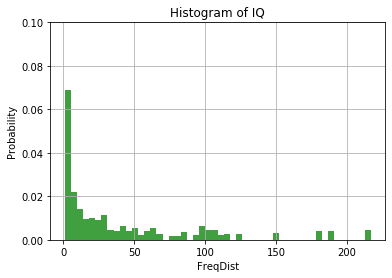

In [11]:
words = []
[words.extend(sentence) for sentence in X]
freqdist = nltk.FreqDist(words)
x_plot = [freqdist[word] for word in words]

# the histogram of the data
n, bins, patches = plt.hist(x_plot, 50, density=1, facecolor='g', alpha=0.75)


plt.xlabel('FreqDist')
plt.ylabel('Probability')
plt.title('Histogram of IQ')
plt.axis([min(x_plot)-10, max(x_plot)+ 10, 0, 0.1])
plt.grid(True)
plt.show()

In [12]:
X_padded = pad_sequences(X, maxlen=SEQUENCE_LENGTH, padding='post', value=0)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.1, random_state=42)

<h1>Validation Test</h1>

In [14]:
word_embedding.shape

(2365, 100)

<h2>LSTM</h2>

In [18]:
model_val = Sequential()
model_val.add(Embedding(
    input_dim=len(tokenizer.word_index)+1, 
    output_dim=EMBEDDING_SIZE, 
    input_length=SEQUENCE_LENGTH, 
    weights=[word_embedding],
    trainable=False))
model_val.add(LSTM(128, recurrent_dropout=0.2))
model_val.add(Dropout(0.3))
model_val.add(Dense(2, activation="softmax"))
# compile as rmsprop optimizer
# aswell as with recall metric
model_val.compile(optimizer="rmsprop", loss="categorical_crossentropy", 
      metrics=["accuracy", f1_m])
model_val.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          236500    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 354,006
Trainable params: 117,506
Non-trainable params: 236,500
_________________________________________________________________


In [19]:
model_val.fit(X_train, y_train, epochs=100, batch_size=64, shuffle=True, validation_split=0.3)

Train on 303 samples, validate on 131 samples
Epoch 1/100
303/303 [==============================] - 3s 10ms/sample - loss: 0.8714 - accuracy: 0.6634 - f1_m: 0.6195 - val_loss: 0.5846 - val_accuracy: 0.6870 - val_f1_m: 0.6806
Epoch 2/100
303/303 [==============================] - 1s 4ms/sample - loss: 0.5412 - accuracy: 0.7426 - f1_m: 0.7461 - val_loss: 0.5415 - val_accuracy: 0.7099 - val_f1_m: 0.8021
Epoch 3/100
303/303 [==============================] - 1s 4ms/sample - loss: 0.5324 - accuracy: 0.7327 - f1_m: 0.7356 - val_loss: 0.4948 - val_accuracy: 0.7176 - val_f1_m: 0.8073
Epoch 4/100
303/303 [==============================] - 1s 4ms/sample - loss: 0.5289 - accuracy: 0.7327 - f1_m: 0.7311 - val_loss: 0.5005 - val_accuracy: 0.7557 - val_f1_m: 0.8333
Epoch 5/100
303/303 [==============================] - 1s 4ms/sample - loss: 0.5340 - accuracy: 0.7261 - f1_m: 0.7271 - val_loss: 0.5557 - val_accuracy: 0.7023 - val_f1_m: 0.6910
Epoch 6/100
303/303 [==============================] - 1s 

303/303 [==============================] - 1s 4ms/sample - loss: 0.5152 - accuracy: 0.7591 - f1_m: 0.7617 - val_loss: 0.4873 - val_accuracy: 0.7634 - val_f1_m: 0.8385
Epoch 47/100
303/303 [==============================] - 1s 4ms/sample - loss: 0.5246 - accuracy: 0.7195 - f1_m: 0.7231 - val_loss: 0.4823 - val_accuracy: 0.7710 - val_f1_m: 0.8438
Epoch 48/100
303/303 [==============================] - 1s 4ms/sample - loss: 0.4937 - accuracy: 0.7822 - f1_m: 0.7779 - val_loss: 0.4821 - val_accuracy: 0.8168 - val_f1_m: 0.8750
Epoch 49/100
303/303 [==============================] - 1s 4ms/sample - loss: 0.5197 - accuracy: 0.7261 - f1_m: 0.7191 - val_loss: 0.4905 - val_accuracy: 0.7176 - val_f1_m: 0.8073
Epoch 50/100
303/303 [==============================] - 1s 4ms/sample - loss: 0.5154 - accuracy: 0.7690 - f1_m: 0.7699 - val_loss: 0.4911 - val_accuracy: 0.7176 - val_f1_m: 0.8073
Epoch 51/100
303/303 [==============================] - 1s 4ms/sample - loss: 0.4977 - accuracy: 0.7723 - f1_m: 0

303/303 [==============================] - 1s 4ms/sample - loss: 0.5126 - accuracy: 0.7558 - f1_m: 0.7552 - val_loss: 0.4803 - val_accuracy: 0.7786 - val_f1_m: 0.8490
Epoch 92/100
303/303 [==============================] - 1s 4ms/sample - loss: 0.5030 - accuracy: 0.7492 - f1_m: 0.7501 - val_loss: 0.4962 - val_accuracy: 0.7176 - val_f1_m: 0.8073
Epoch 93/100
303/303 [==============================] - 1s 4ms/sample - loss: 0.4999 - accuracy: 0.7921 - f1_m: 0.7918 - val_loss: 0.4797 - val_accuracy: 0.8015 - val_f1_m: 0.8646
Epoch 94/100
303/303 [==============================] - 1s 4ms/sample - loss: 0.5078 - accuracy: 0.7525 - f1_m: 0.7475 - val_loss: 0.4888 - val_accuracy: 0.8092 - val_f1_m: 0.8698
Epoch 95/100
303/303 [==============================] - 1s 4ms/sample - loss: 0.4869 - accuracy: 0.7558 - f1_m: 0.7529 - val_loss: 0.4781 - val_accuracy: 0.7710 - val_f1_m: 0.8438
Epoch 96/100
303/303 [==============================] - 1s 4ms/sample - loss: 0.5035 - accuracy: 0.7789 - f1_m: 0

In [23]:
loss, accuracy, f1_score = model_val.evaluate(X_train, y_train, verbose=0)
print('loss: ', loss, ', accuracy: ', accuracy, ', f1 score: ', f1_score)

loss:  0.4738161335892392 , accuracy:  0.7718894 , f1 score:  0.7703372


<h2>Bidirectional LSTM</h2>

In [31]:
model_2_val = Sequential()
model_2_val.add(Embedding(
    input_dim=len(tokenizer.word_index)+1, 
    output_dim=EMBEDDING_SIZE, 
    input_length=SEQUENCE_LENGTH, 
    weights=[word_embedding],
    trainable=False))
model_2_val.add(Bidirectional(LSTM(128)))
model_2_val.add(Dropout(0.3))
model_2_val.add(Dense(2, activation="softmax"))
# compile as rmsprop optimizer
# aswell as with recall metric
model_2_val.compile(optimizer="rmsprop", loss="categorical_crossentropy", 
      metrics=["accuracy", f1_m])
model_2_val.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          236500    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 471,510
Trainable params: 235,010
Non-trainable params: 236,500
_________________________________________________________________


In [32]:
model_2_val.fit(X_train, y_train, epochs=100, batch_size=64, shuffle=True, validation_split=0.3)

Train on 303 samples, validate on 131 samples
Epoch 1/100
303/303 [==============================] - 9s 31ms/sample - loss: 0.6701 - accuracy: 0.6271 - f1_m: 0.6277 - val_loss: 0.6299 - val_accuracy: 0.6947 - val_f1_m: 0.6858
Epoch 2/100
303/303 [==============================] - 1s 3ms/sample - loss: 0.6050 - accuracy: 0.7096 - f1_m: 0.7114 - val_loss: 0.5796 - val_accuracy: 0.6870 - val_f1_m: 0.6806
Epoch 3/100
303/303 [==============================] - 1s 3ms/sample - loss: 0.5704 - accuracy: 0.7261 - f1_m: 0.7259 - val_loss: 0.5286 - val_accuracy: 0.7863 - val_f1_m: 0.8542
Epoch 4/100
303/303 [==============================] - 1s 3ms/sample - loss: 0.5460 - accuracy: 0.7690 - f1_m: 0.7666 - val_loss: 0.5059 - val_accuracy: 0.8092 - val_f1_m: 0.8698
Epoch 5/100
303/303 [==============================] - 1s 3ms/sample - loss: 0.5237 - accuracy: 0.7558 - f1_m: 0.7563 - val_loss: 0.5029 - val_accuracy: 0.7786 - val_f1_m: 0.8490
Epoch 6/100
303/303 [==============================] - 1s 

303/303 [==============================] - 1s 3ms/sample - loss: 0.4761 - accuracy: 0.7690 - f1_m: 0.7733 - val_loss: 0.4779 - val_accuracy: 0.7939 - val_f1_m: 0.8594
Epoch 47/100
303/303 [==============================] - 1s 3ms/sample - loss: 0.4747 - accuracy: 0.7822 - f1_m: 0.7824 - val_loss: 0.4671 - val_accuracy: 0.7939 - val_f1_m: 0.8594
Epoch 48/100
303/303 [==============================] - 1s 3ms/sample - loss: 0.5046 - accuracy: 0.7756 - f1_m: 0.7762 - val_loss: 0.4761 - val_accuracy: 0.7863 - val_f1_m: 0.8542
Epoch 49/100
303/303 [==============================] - 1s 3ms/sample - loss: 0.4867 - accuracy: 0.7657 - f1_m: 0.7657 - val_loss: 0.4693 - val_accuracy: 0.7863 - val_f1_m: 0.8542
Epoch 50/100
303/303 [==============================] - 1s 3ms/sample - loss: 0.4893 - accuracy: 0.7822 - f1_m: 0.7791 - val_loss: 0.5156 - val_accuracy: 0.7481 - val_f1_m: 0.8281
Epoch 51/100
303/303 [==============================] - 1s 3ms/sample - loss: 0.4807 - accuracy: 0.7723 - f1_m: 0

303/303 [==============================] - 1s 3ms/sample - loss: 0.4841 - accuracy: 0.7690 - f1_m: 0.7699 - val_loss: 0.4823 - val_accuracy: 0.7786 - val_f1_m: 0.8490
Epoch 92/100
303/303 [==============================] - 1s 3ms/sample - loss: 0.4688 - accuracy: 0.7888 - f1_m: 0.7864 - val_loss: 0.4640 - val_accuracy: 0.7939 - val_f1_m: 0.8594
Epoch 93/100
303/303 [==============================] - 1s 3ms/sample - loss: 0.4776 - accuracy: 0.7756 - f1_m: 0.7739 - val_loss: 0.4686 - val_accuracy: 0.8092 - val_f1_m: 0.8698
Epoch 94/100
303/303 [==============================] - 1s 3ms/sample - loss: 0.4787 - accuracy: 0.7789 - f1_m: 0.7805 - val_loss: 0.4621 - val_accuracy: 0.7939 - val_f1_m: 0.8594
Epoch 95/100
303/303 [==============================] - 1s 3ms/sample - loss: 0.4622 - accuracy: 0.7855 - f1_m: 0.7856 - val_loss: 0.4717 - val_accuracy: 0.8015 - val_f1_m: 0.8646
Epoch 96/100
303/303 [==============================] - 1s 3ms/sample - loss: 0.4783 - accuracy: 0.7822 - f1_m: 0

In [33]:
loss_2, accuracy_2, f1_score_2 = model_2_val.evaluate(X_train, y_train, verbose=0)
print('loss: ', loss_2, ', accuracy: ', accuracy_2, ', f1 score: ', f1_score_2)

loss:  0.4780027109631745 , accuracy:  0.78341013 , f1 score:  0.78497016
